# Train, Test, and Redeploy Our LLM

This notebook demonstrates how to train a Hugging Face LLM, fine-tunning it to a specific data and build an automated ML pipeline for data collection and preparation, training, evaluation, testing and deployment of an application pipeline with the new LLM.

The [**previous notebook**](./01-serving.ipynb) used the standard `GPT2-Medium` from Hugging Face models which generated ppoorly when asking itt about MLOps, butt it is all about tto change.

The tutorial has two main steps:
1. [Define MLRun project and set all mlrun function](#project-setup)
2. [Run full LLM life-cycle workflow](#full-workflow)
3. [Try the new model with Gradio](#use-gradio)

___
<a id="project-setup"></a>
## 1. Define MLRun project and set all mlrun function

Create or load an MLRun project that holds all your functions and configuration ([**project_setup.py**](./src/project_setup.py))

The project contains the following files:
* [data_collection.py](./src/data_collection.py) - Collect all text from given list of urls.
* [data_preprocess.py](./src/data_preprocess.py) - Preprocess the data and save it as a `pd.DataFrame` dataset arttifact.
* [training.py]() - Train and evaluate using HuggingFace `Trainer` API and DeepSpeed empowered by **MLRun's auto-logging** (`apply_mlrun` function).
* [serving.py](./src/serving.py) - Multiple model servers and serving steps to build the **Serving Graph** from notebook 01.
* [testing.py](./src/testing.py) - Stress testing the serving graph.

And a training pipeline (in [**training_workflow.py**](./src/training_workflow.py))

The training and evaluation function we will use is [hugging_face_classifier_trainer](https://www.mlrun.org/hub/). It is taken from [**MLRun's Functions Hub**](https://docs.mlrun.org/en/stable/runtimes/load-from-hub.html) - a collection of ready to be imported functions for variety of use cases. We import the function during the project setup.

In [3]:
import mlrun
from src.project_setup import create_and_set_project

project = create_and_set_project(
    git_source="git://github.com/yonishelach/learn-docs.git#main",
    name="mlopspedia",
    default_image="yonishelach/mlrun-hf",
    user_project=True,
)

> 2023-05-09 20:06:18,221 [info] loaded project mlopspedia from MLRun DB


___
<a id="full-workflow"></a>
## 2. Run full LLM life-cycle workflow

Run the training pipeline (in [training_workflow.py](./src/training_workflow.py)) by using `project.run(workflow name, ...)`:

    collect_html_to_text_files -> prepare_dataset -> train -> (serving graph) -> model_server_tester
                                                           -> evaluate
                                                          
* `collect_html_to_text_files` (Data Collection) - Collect all text from given html urls into `.txt` files.
* `prepare_dataset` (Preprocess Data) - Join the `.txt` files, reformatting the text into our "Subject - Content" prompt template. We made every header (`<h>` tags) a *subject* of a prompt, and the text (`<p>` tags) under it as its *content*.
* `train` - Fine-tune the LLM on the data. We'll run the training on **OpenMPI** and we will use **DeepSpeed** for distributing the model and data between multiple workers, splitting the work between nodes and GPUs.
* `evaluate` - Evaluate our model using the *Perplexity* metric.
* Deployment - Deploy the same serving graph we saw on notebook 01: `-> preprocess -> llm -> postprocess -> toxicity classifier ->`
* `model_server_tester` (Stress Test) - Send data to our serving endpoint and get a performance report.

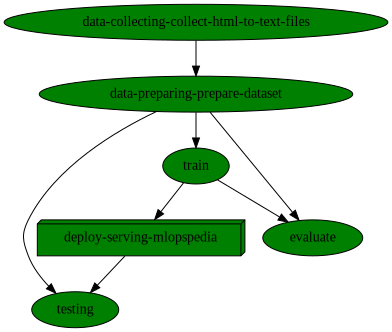

uid,start,state,name,parameters,results
...8e7726ec,May 09 19:49:09,completed,testing,endpoint=http://mlopspedia-admin-serving-mlopspedia-mlopspedia-admin.default-tenant.app.llm.iguazio-cd1.com/,count=5error_count=0avg_latency=18min_latency=8max_latency=29
...95209624,May 09 19:44:27,completed,evaluate,model_path=store://artifacts/mlopspedia-admin/gpt2-medium-mlrun:eddc078e-d1b6-474c-8464-33de2dc84ec7,perplexity=5.092374324798584
...c1e0b455,May 09 19:26:38,completed,train,model_name=gpt2-medium-mlrunpretrained_tokenizer=gpt2-mediumpretrained_model=gpt2-mediummodel_class=transformers.GPT2LMHeadModeltokenizer_class=transformers.GPT2TokenizerTRAIN_num_train_epochs=15TRAIN_fp16=TrueTRAIN_bf16=FalseTRAIN_per_device_train_batch_size=4TRAIN_logging_strategy=epochuse_deepspeed=True,loss=1.6697learning_rate=5e-05train_runtime=600.2626train_samples_per_second=14.369train_steps_per_second=0.225total_flos=8471017684992.0
...81e35d81,May 09 19:14:30,completed,data-preparing-prepare-dataset,,
...b27450fa,May 09 19:13:50,completed,data-collecting-collect-html-to-text-files,urls=https://www.iguazio.com/blog/,


In [2]:
workflow_run = project.run(
    name="training_workflow",
    arguments={
        "html_links": 'https://www.iguazio.com/blog/',
        "model_name": "gpt2-medium-mlrun",
        "pretrained_tokenizer": "gpt2-medium",
        "pretrained_model": "gpt2-medium",
        "model_class": "transformers.GPT2LMHeadModel",
        "tokenizer_class": "transformers.GPT2Tokenizer",
        "epochs": 15,
        "use_deepspeed": True,
    },
    watch=True,
    dirty=True
)

Here we can see how the workflow looks on our UI & Also the result of the trainer and the server_tester

<img src="./images/workflow.png" alt="workflow" width="1200"/>

<img src="./images/latancy.png" alt="latancy" width="1200"/>

___
<a id="use-gradio"></a>
## Try the new model with Gradio

Once the pipeline completes, you can try the model using the function `invoke()` method or Gradio. You can get the new function object using the project `get_function()` method. 

In [4]:
serving_function = project.get_function("serving-mlopspedia")

In [6]:
import gradio as gr
import requests

serving_function._get_state()
serving_url = serving_function._resolve_invocation_url("", False)

def generate(text):
    # call the serving function with the input text
    resp = requests.post(serving_url, data=text)
    return resp.json()["outputs"]

with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="MLOps Subject to ask about:", placeholder="Please insert text", value="What are training pipelines?")]
    output = [gr.Textbox(label="Generated Answer")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=generate, inputs=input_box, outputs=output)

In [8]:
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://7129e943151027812d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


**Done !**